In [1]:
# importing data and auxiliar functions

import bikescience.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString
import ast

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time
import scipy.stats as st

# read routes files and join with general trips file
od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}
od_routes_sp['length'] = od_routes_sp['geometry'].length * 100000

routes_pedestrian = pd.read_csv('../data/sao-paulo/rotas-migracao/routes_pedestrian.csv')
routes_pedestrian.set_index('trip_id', inplace=True, drop=False)
routes_pedestrian = routes_pedestrian.join(other = od_trips, how = 'left')
routes_pedestrian = gpd.GeoDataFrame(routes_pedestrian, crs={'init': 'epsg:4326'}, 
                                     geometry=[LineString(ast.literal_eval(r)) for r in routes_pedestrian.route])
routes_pedestrian['length'] = routes_pedestrian['geometry'].length * 100000

routes_car = pd.read_csv('../data/sao-paulo/rotas-migracao/new_routes_cars.csv')
routes_car.set_index('trip_id', inplace=True, drop=False)
routes_car = routes_car.join(other = od_trips, how = 'left')
routes_car = gpd.GeoDataFrame(routes_car, crs={'init': 'epsg:4326'}, 
                              geometry=[LineString(ast.literal_eval(r)) for r in routes_car.route])
routes_car['length'] = routes_car['geometry'].length * 100000

the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


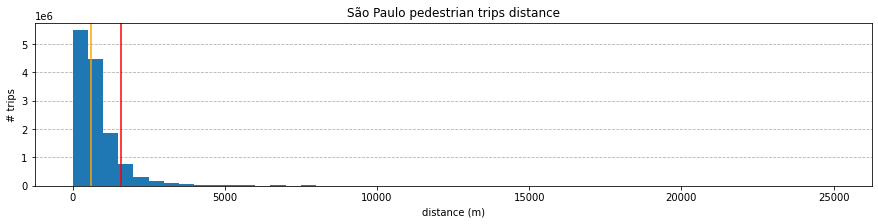

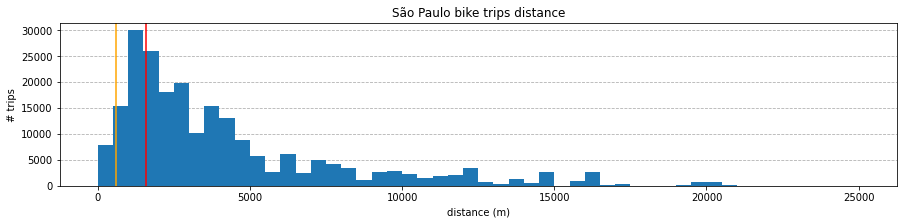

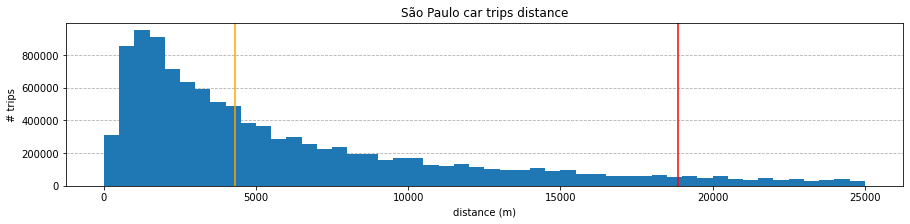

In [2]:
df = routes_pedestrian
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - 1e-5:
            stats.append(i[value])
    return stats

s = stats(df, 'length')
    
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=df['length'], 
         weights = df['FE_VIA'],range=(0, 25000))
plt.title('São Paulo pedestrian trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0, 25000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show() 

df = routes_car
s = stats(df, 'length')
        
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=df['length'], 
         weights = df['FE_VIA'],range=(0, 25000))
plt.title('São Paulo car trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

In [53]:
genders = {1: 'm', 2: 'f', 'm': 'm', 'f': 'f'}

distribs = {
    'distance_m':    (st.invweibull, (1.9624908421440037, -1358.5912359607478, 3558.697966253873)),
    'distance_f':    (st.johnsonsu,  (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386)),
    'age_m':         (st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868)),
    'age_f':         (st.loggamma,   (897.3569843061273, -2332.923603808461, 347.1732584129129)),
    'slope_0_m':     (st.halfgennorm, (0.5938931306470469, -0.24400150361767925, 331.4710613095754)) ,
    'slope_1_m':     (st.wald, (-104.76240577720931, 685.9786628776621)) ,
    'slope_2_m':     (st.invgauss, (2.108522364223588, -32.82673098772308, 182.06556527798517)) ,
    'slope_3_m':     (st.invgauss, (2.688687820077516, -21.13444964695273, 97.67944984207021)) ,
    'slope_4_m':     (st.invgauss, (5.502101429028432, -8.13123108843531, 30.571313764443463)) ,
    'slope_5_m':     (st.halfcauchy, (-1.4470696301679076e-08, 44.668468802008306)) ,
    'slope_6_m':     (st.beta, (0.8131995575475309, 331.1621037526766, -1.631515678560271e-25, 20738.671835648325)) ,
    'slope_7_m':     (st.foldcauchy, (0.0944460919704757, -0.7864682761930095, 9.393897207087463)) ,
    'slope_8_m':     (st.foldcauchy, (0.00673535113084469, -3.1474534806095553e-09, 4.321341682356357)) ,
    'slope_9_m':     (st.pearson3, (2.2573136160688976, 10.607177295812832, 11.97186286894759)) ,
    'slope_10_m':    (st.wald, (-4.043061534826781, 14.276893670640046)),
    'slope_0_f':     (st.exponpow, (0.5605940467562757, -1.8784725802483102e-25, 1565.4492572779232)),
    'slope_1_f':     (st.gengamma, (0.590524483516389, 1.0275914711243868, -8.664310862508725e-28, 677.519552928482)),
    'slope_2_f':     (st.gengamma, (0.47380391166676794, 1.1693288358580536, -8.062714753528154e-30, 406.8704200176831)),
    'slope_3_f':     (st.halfcauchy, (-1.6974581783015064e-09, 59.79317588661688)),
    'slope_4_f':     (st.halfcauchy, (-1.9353863324140777e-10, 5.523495637773543)),
    'slope_5_f':     (st.gilbrat, (-8.883473023487747, 29.8148343960495)),
    'slope_6_f':     (st.gilbrat, (-6.238336526524279, 19.324184822768018)),
    'slope_7_f':     (st.pearson3, (2.2988440861319095, 15.545779168414187, 17.868661252810796)),
    'slope_8_f':     (st.wald, (-6.11511658910011, 21.926956014811573)),
    'slope_9_f':     (st.wald, (-3.6592002310221847, 12.678789700411755)),
    'slope_10_f':    (st.gilbrat, (-1.3698237608138852, 3.9046811037876776))
}

def scale_potential_to_1 (x, distribution, param):
    d = dist.make_pdf(distribution, param)
    max_value = max (x for x in d)
    
    y = distribution.pdf(x, *param)
    return y / max_value

def partial_cycling_potential (variable, gender, value):
    d = distribs[variable + '_' + genders[gender]]
    return scale_potential_to_1 (value, d[0], d[1])

# Return a dict with how many meters were traveled in each slope degree
def meters_per_degree (route):
    d = {}
    stretchs = split_route(route, 'line', False)
    for st in stretchs:
        degree = str(min(10, round(st[1])))
        if degree not in d.keys():
            d[degree] = 0
        d[degree] += st[0].length * 100000
    return d

def inclination_potential (route, gender):
    meters_dict = meters_per_degree(route)
    potential = 0
    weights = 0
    for degree, meters in meters_dict.items():
        d = int(degree)
        if (d > 0): 
            weights += d
            potential_value = partial_cycling_potential ('slope_' + degree, gender, meters) 
            potential += (1 - potential_value) * d
    
    if weights == 0:
        return 0
    return potential / weights

def cycling_potential (trip):
    pot_d = partial_cycling_potential ('distance', trip['SEXO'], trip['length'])
    pot_a = partial_cycling_potential ('age', trip['SEXO'], trip['IDADE'])
    pot_i = inclination_potential (trip['geometry'], trip['SEXO'])
    
    return pot_d, pot_a, 1 - pot_i

In [ ]:
cp = []
for i, r in od_routes_sp.iterrows():
    pot_d, pot_a, pot_i = cycling_potential(r)
    cp.append(['bike', i, pot_d, pot_a, pot_i, 1])
    
for i, r in routes_pedestrian.iterrows():
    try:
        pot_d, pot_a, pot_i = cycling_potential(r)
        cp.append(['pedestrian', i, pot_d, pot_a, pot_i, 0])
    except:
        print(i, '- broken case')
    
for i, r in routes_car.iterrows():
    try:
        pot_d, pot_a, pot_i = cycling_potential(r)
        cp.append(['car', i, pot_d, pot_a, pot_i, 0])
    except:
        print(i, '- broken case')

In [56]:
columns = ['modal', 'trip_id', 'distance_potential', 'age_potential', 'inclination_potential', 'is_bike']
df_cycling_potential = pd.DataFrame(data = cp, columns = columns)

display (df_cycling_potential)

modal   trip_id  distance_potential  age_potential  \
0       bike       0.0            0.907533       0.045080   
1       bike       1.0            0.826459       0.045080   
2       bike       2.0            0.907533       0.045080   
3       bike       3.0            0.826459       0.045080   
4       bike       4.0            0.823677       0.045080   
...      ...       ...                 ...            ...   
100426   car  182862.0            0.319052       0.323018   
100427   car  183002.0            0.000962       0.848482   
100428   car  183003.0            0.001228       0.848482   
100429   car  183076.0            0.006880       0.075749   
100430   car  183077.0            0.006664       0.075749   

        inclination_potential  is_bike  
0                    0.854991        1  
1                    0.803336        1  
2                    0.854991        1  
3                    0.803336        1  
4                    0.815066        1  
...                       ...      ...  
100426               0.924637        0  
100427               0.999933        0  
100428               0.999908        0  
100429               0.988176        0  
100430               0.994329        0  

[100431 rows x 6 columns]

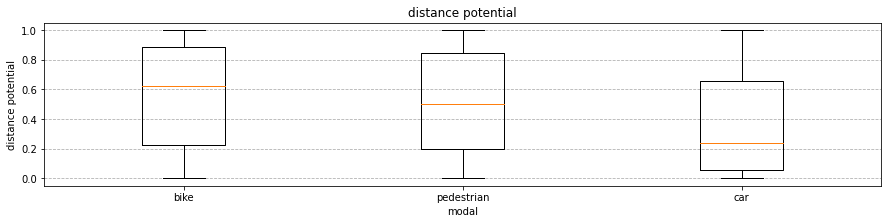

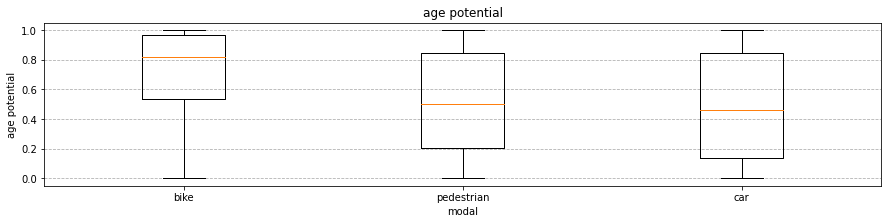

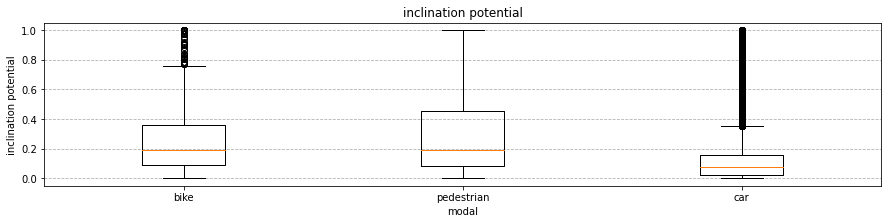

In [62]:
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['distance_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['distance_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['distance_potential']],
           showfliers=False)
plt.xticks([1, 2, 3], ['bike', 'pedestrian', 'car'])
plt.title('distance potential')
plt.xlabel('modal')
plt.ylabel('distance potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['age_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['age_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['age_potential']],
           showfliers=False)
plt.xticks([1, 2, 3], ['bike', 'pedestrian', 'car'])
plt.title('age potential')
plt.xlabel('modal')
plt.ylabel('age potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['inclination_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['inclination_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['inclination_potential']])
plt.xticks([1, 2, 3], ['bike', 'pedestrian', 'car'])
plt.title('inclination potential')
plt.xlabel('modal')
plt.ylabel('inclination potential')
plt.show()

In [61]:
fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)

for _, r in od_routes_sp.iterrows():
    p = partial_cycling_potential ('distance', genders[r['SEXO']], r['length'])
    if p > .8:
        color='#2acf06'
    elif p > .6:
        color='#8ae736'
    elif p > .4:
        color='ecff1e'
    elif p > .2:
        color='#f7d202'
    else:
        color='#ff1e1e'
    folium.GeoJson(r['geometry'], 
                   control=False, 
                   style_function=lambda style, color_p=color :{'color': color_p, 'weight': 1}).add_to(fmap)
    
display(fmap)

In [84]:

aux = df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike'].sort_values('inclination_potential')

#display(aux.loc[aux['inclination_potential'] < 0.9].tail(15))

#display(od_routes_sp['ID_ORDEM'])

fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
plot_slope(fmap, od_routes_sp.loc[od_routes_sp['ID_ORDEM'] == 165586].iloc[0]['geometry'], 'line')
display(fmap)

pot = cycling_potential(od_routes_sp.loc[od_routes_sp['ID_ORDEM'] == 165586].iloc[0])
print('Distance potential:    ', pot[0])
print('Age potential:         ', pot[1])
print('Inclination potential: ', pot[2])

fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)
plot_slope(fmap, od_routes_sp.loc[od_routes_sp['ID_ORDEM'] == 453].iloc[0]['geometry'], 'line')
display(fmap)

pot = cycling_potential(od_routes_sp.loc[od_routes_sp['ID_ORDEM'] == 453].iloc[0])
print('Distance potential:    ', pot[0])
print('Age potential:         ', pot[1])
print('Inclination potential: ', pot[2])

Distance potential:     0.6911246609770747
Age potential:          0.6854338964350939
Inclination potential:  0.22787581302308124


Distance potential:     0.8264593921991638
Age potential:          0.045080018696440925
Inclination potential:  0.19666405889249328
